In [1]:
from qiskit import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmqx2')

In [56]:
backend.properties().qubits

[[Nduv(datetime.datetime(2020, 6, 26, 8, 22, 8, tzinfo=tzutc()), T1, µs, 65.08681549583736),
  Nduv(datetime.datetime(2020, 6, 26, 8, 23, 6, tzinfo=tzutc()), T2, µs, 78.74490689224909),
  Nduv(datetime.datetime(2020, 6, 26, 8, 56, 38, tzinfo=tzutc()), frequency, GHz, 5.2863972381246604),
  Nduv(datetime.datetime(2020, 6, 26, 8, 21, 53, tzinfo=tzutc()), readout_error, , 0.026499999999999968),
  Nduv(datetime.datetime(2020, 6, 26, 8, 21, 53, tzinfo=tzutc()), prob_meas0_prep1, , 0.027000000000000024),
  Nduv(datetime.datetime(2020, 6, 26, 8, 21, 53, tzinfo=tzutc()), prob_meas1_prep0, , 0.026)],
 [Nduv(datetime.datetime(2020, 6, 25, 8, 24, 19, tzinfo=tzutc()), T1, µs, 68.33671200505869),
  Nduv(datetime.datetime(2020, 6, 26, 8, 24, 3, tzinfo=tzutc()), T2, µs, 42.94114051543119),
  Nduv(datetime.datetime(2020, 6, 26, 8, 56, 38, tzinfo=tzutc()), frequency, GHz, 5.2382646908105155),
  Nduv(datetime.datetime(2020, 6, 26, 8, 21, 53, tzinfo=tzutc()), readout_error, , 0.014499999999999957),
  Ndu

In [8]:
"""
Taken from https://qiskit.org/documentation/apidoc/characterization.html
"""
from qiskit.ignis.characterization.gates import *
circuit = ampcal_1Q_circuits(75, [0])
job = qiskit.execute(circuit[0], backend=backend, shots=1024)

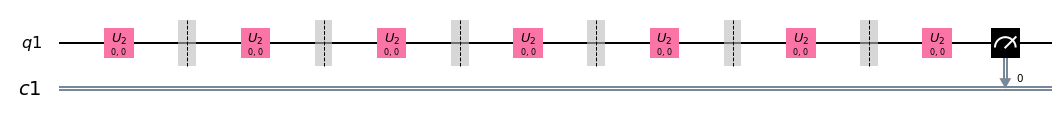

In [44]:
circuit[0][3].draw(output='mpl')

In [20]:
circuit1 = anglecal_1Q_circuits(75, [0])
job1 = qiskit.execute(circuit1[0], backend=backend, shots=1024)



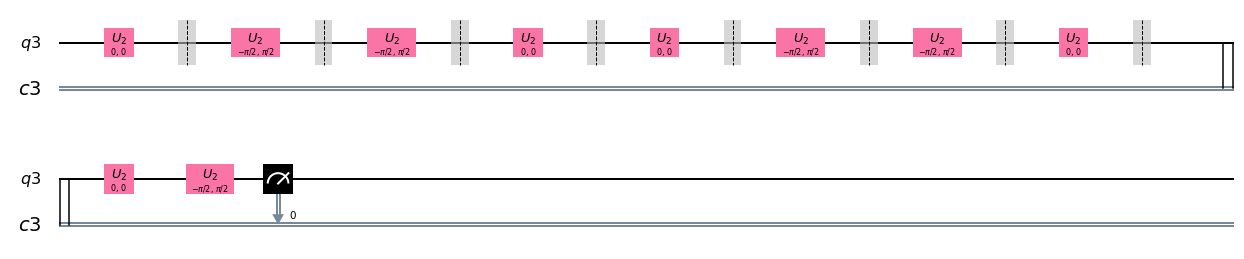

In [51]:
circuit1[0][2].draw(output='mpl')

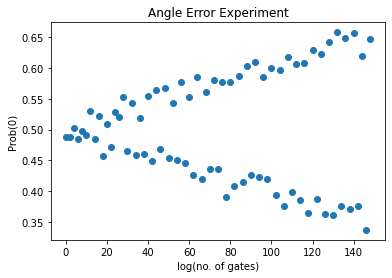

In [52]:
p0 = list(map(lambda x: x['1']/1024, job1.result().get_counts()))
plt.xlabel('log(no. of gates)')
plt.ylabel('Prob(0)')
plt.title ('Angle Error Experiment')
plt.scatter(circuit1[1], p0)

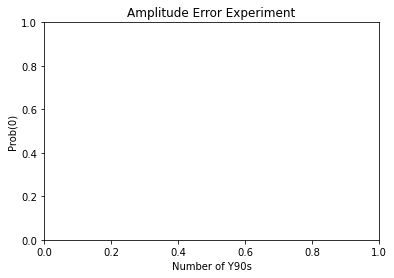

In [41]:

plt.show()